In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('dispCDF40_ver4.2.in.txt', delim_whitespace=True, comment='#')

df = df.rename(columns={
    'length': 'L',
    'width': 'W',
    'long': 'lon'
})

df['L'] = 1000*df['L']
df['W'] = 1000*df['W']
df['depth'] *=1000
df['reference'] = 'center'
df.head()

,L,W,depth,strike,dip,rake,slip,lat,lon,reference
0,50000.0,50000.0,0.0,193.0,14.0,81.0,0.00,39.738,144.331,center
1,50000.0,50000.0,0.0,193.0,14.0,81.0,0.00,39.300,144.200,center
2,50000.0,50000.0,0.0,193.0,14.0,81.0,5.66,38.862,144.069,center
3,50000.0,50000.0,0.0,193.0,14.0,81.0,41.15,38.424,143.939,center
4,50000.0,50000.0,0.0,193.0,14.0,81.0,47.93,37.986,143.810,center


In [4]:
df = pd.read_csv('usgs.txt', delim_whitespace=True)
df = df.rename(columns={
    'Lat.': 'lat',
    'Lon.': 'lon'
})
df['L'] = 25000
df['W'] = 16600
df['slip'] *= 0.01
df['depth'] *= 1000
df['reference'] = 'center'
print(df['slip'].min(),df['slip'].max())
print(df['depth'].min(),df['depth'].max())

df.head()

0.0006168 55.026870100000004
2932.7000000000003 50815.9


,lat,lon,depth,slip,rake,strike,dip,t_rup,t_ris,t_fal,mo,L,W,reference
0,40.6019,143.72940,15193.4,0.573538,117.14320,198.0,15.0,148.0,6.4,4.8,9.758958e+25,25000,16600,center
1,40.3879,143.64079,15193.4,1.410308,87.10259,198.0,15.0,140.0,8.0,14.4,2.399689e+26,25000,16600,center
2,40.1740,143.55220,15193.4,0.349885,83.75771,198.0,15.0,128.0,19.2,1.6,5.953423e+25,25000,16600,center
3,39.9600,143.46359,15193.4,2.199107,101.95310,198.0,15.0,100.0,8.0,17.6,3.741859e+26,25000,16600,center
4,39.7460,143.37500,15193.4,5.213699,92.39947,198.0,15.0,76.0,9.6,1.6,8.871303e+26,25000,16600,center


In [5]:
df.to_csv('earthquake.csv',index=False)

# Easywave

In [6]:
df_easywave = df.copy()
df_easywave['reference']='C'
df_easywave['depth'] /=1000
df_easywave['L'] /=1000
df_easywave['W'] /=1000

In [7]:
f = open('fault.flt','w')

for index, row in df.iterrows():
    
    rowString = '-location {lon} {lat} {depth} -refpos {reference} -strike {strike} -dip {dip} -rake {rake} -slip {slip} -size {L} {W}\n'
    rowString = rowString.format(**row)
    f.write(rowString)

f.close()

# Geoclaw

In [8]:
from clawpack.geoclaw import dtopotools

In [9]:
df_geoclaw = df.copy()

In [10]:
fault = dtopotools.Fault()
fault.subfaults = []
for index, fault_row in df_geoclaw.iterrows():
    subfault = dtopotools.SubFault()
    subfault.strike = fault_row["strike"]
    subfault.length = fault_row["L"]
    subfault.width = fault_row["W"]
    subfault.depth = fault_row["depth"]
    subfault.slip = fault_row["slip"]
    subfault.rake = fault_row["rake"]
    subfault.dip = fault_row["dip"]
    subfault.longitude = fault_row["lon"]
    subfault.latitude = fault_row["lat"]
    subfault.coordinate_specification = "centroid"
    fault.subfaults.append(subfault)

In [24]:
df.head()

,lat,lon,depth,slip,rake,strike,dip,t_rup,t_ris,t_fal,mo,L,W,reference
0,40.6019,143.72940,15193.4,0.573538,117.14320,198.0,15.0,148.0,6.4,4.8,9.758958e+25,25000,16600,center
1,40.3879,143.64079,15193.4,1.410308,87.10259,198.0,15.0,140.0,8.0,14.4,2.399689e+26,25000,16600,center
2,40.1740,143.55220,15193.4,0.349885,83.75771,198.0,15.0,128.0,19.2,1.6,5.953423e+25,25000,16600,center
3,39.9600,143.46359,15193.4,2.199107,101.95310,198.0,15.0,100.0,8.0,17.6,3.741859e+26,25000,16600,center
4,39.7460,143.37500,15193.4,5.213699,92.39947,198.0,15.0,76.0,9.6,1.6,8.871303e+26,25000,16600,center


In [32]:
slack = 3
lat_min = df["lat"].min() - slack
lat_max = df["lat"].max() + slack
lon_min = df["lon"].min() - slack
lon_max = df["lon"].max() + slack
print(lat_min, lat_max, lon_min, lon_max)

32.2384 43.909 137.29648999999998 147.6519


In [33]:
x = np.linspace(lon_min, lon_max, 100)
y = np.linspace(lat_min, lat_max, 100)
times = [1.]

In [34]:
fault.create_dtopography(x,y,times)
dtopo = fault.dtopo
dtopo_fname = "earthquake.tt3"
dtopo.write(dtopo_fname, dtopo_type=3)

In [35]:
dtopo_read = dtopotools.DTopography()
dtopo.read(dtopo_fname, dtopo_type=3)

In [36]:
x = dtopo.x
y = dtopo.y

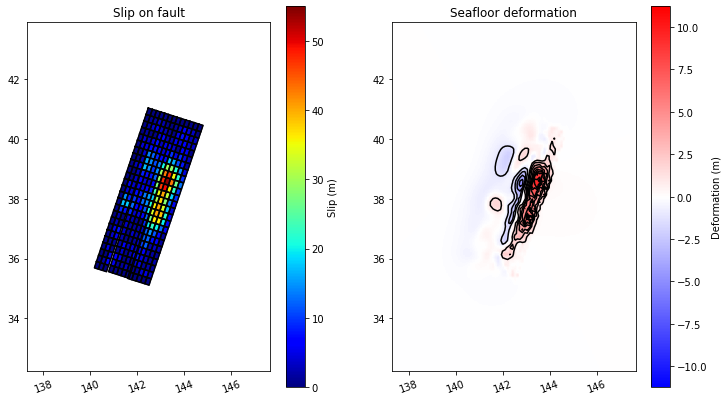

In [37]:
plt.figure(figsize=(12,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(y.min(),y.max())
dtopo.plot_dZ_colors(t=1.,axes=ax2)